# KIVORK  // тестовое задание

## Вступительная информация для Задания 1:
Приложение - мобильная утилита для сканирования документов. Модель монетизации подписочная, есть пробный период 7 дней с дальнейшим переходом в оплату 4.99 USD в неделю. По ссылке ниже выгрузка с базы данных по оформлениям подписок и оплат. Каждая строка представляет собой отдельное событие (либо оформление пробной подписки, либо оплата после завершения пробного периода). Задание построено таким образом, чтобы проверить понимание принципов unit-экономики предприятия. Задание 1 предпочтительней делать с помощью Python.

### Загрузка датасета

In [70]:
#импортирую библиотеки
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np

In [71]:
#открываю датасет
df = pd.read_excel('test case data analyst.xlsx')

In [72]:
#проверяем данные
display(df.head())
df.info()

,product_id,quantity,is_trial_period,purchase_date,user_id
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222
1,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,9455582
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114200 entries, 0 to 114199
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   product_id       114200 non-null  object        
 1   quantity         114200 non-null  int64         
 2   is_trial_period  114200 non-null  bool          
 3   purchase_date    114200 non-null  datetime64[ns]
 4   user_id          114200 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(2), object(1)
memory usage: 3.6+ MB


Датасет впорядке, предобработка не требуется

### 1. Необходимо рассчитать текущий LTV юзера, используя когортный анализ (cohorting event - оформление пробного периода, когорта представляет собой кол-во возможных операций).

В описание не указано есть ли возможность у пользователей пользоваться бесплатной версией или возможна только пробная подписка, с последующем переходом в платную. Так как это тестовое задание примем что возможна только пробная подписка с последующей платной.

Исходя из модели подписки, получается что первая дата оплаты(purchase_date) являеться датой первого визита.

In [73]:
#создаю профили пользователей
profiles = (
        df.sort_values(by=['user_id', 'purchase_date'])
        .groupby('user_id')
        .agg({'purchase_date': 'first'})
        .rename(columns={'purchase_date': 'first_ts'})
        .reset_index()  # возвращаем user_id из индекса
    )
#объединяю профили с основным датафреймом
df = df.merge(profiles, on='user_id')
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_ts
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12
1,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-12,9484222,2020-02-12
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10
3,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9422402,2020-02-10
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11


In [74]:
#считаю лайфтайм для каждго события
df['lifetime'] = (df['purchase_date'] - df['first_ts']).dt.days
df.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_ts,lifetime
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-19,9484222,2020-02-12,7
1,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-12,9484222,2020-02-12,0
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-17,9422402,2020-02-10,7
3,1week_4.99_USD_subscription_7days_trial,1,True,2020-02-10,9422402,2020-02-10,0
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-18,4997991,2020-02-11,7


Посмотрим на первую и последнюю зафиксированную дату в датасете

In [75]:
print('Первая дата в датасете:', df['purchase_date'].min())
print('Последняя дата в датасете:', df['purchase_date'].max())

Первая дата в датасете: 2020-01-01 00:00:00
Последняя дата в датасете: 2020-02-20 00:00:00


Посмотрим как распределены лайфтаймы в таблице

<AxesSubplot:ylabel='Frequency'>

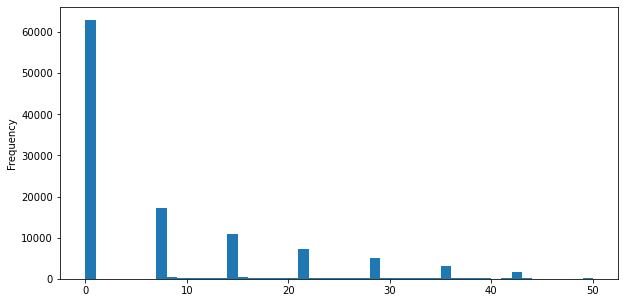

In [76]:
df['lifetime'].plot(kind='hist',bins=50, figsize=(10, 5))

Данные за первый день корректируют масштаб и затрудняют анализ графика. Отсечем первый день

<AxesSubplot:ylabel='Frequency'>

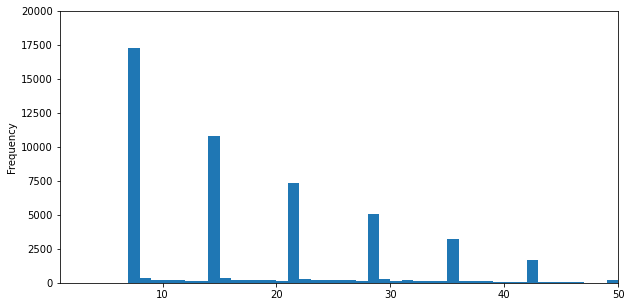

In [77]:
df['lifetime'].plot(kind='hist',bins=50, figsize=(10, 5), xlim=(1,50), ylim=(0,20000))


На графике видны всплески по дням кратным недели, что логично так как подписка понедельная.
Чтобы включить в анализ большое количество пользователей ограничимся анализом 29 дней, так большое количество пользователей из датафрейма "проживут" все лайфтаймы.
Моментом анализа примем последний день то есть 2020-02-20

In [78]:
#определяю момент анализа
observation_date = datetime(2020, 2, 20).date()

#определяю количество дней для анализа
horizon_days = 29

#исключаем пользователей не проживших месяц
last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
result_df = df.query('first_ts <= @last_suitable_acquisition_date')
result_df.head()

#добавляю столбец с доходом от пользователея
result_df.loc[result_df['is_trial_period'] == False, 'revenue'] = 4.99
result_df.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1599: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,product_id,quantity,is_trial_period,purchase_date,user_id,first_ts,lifetime,revenue
8,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,28,4.99
9,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-19,8803657,2020-01-19,0,NaN
10,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-26,8803657,2020-01-19,7,4.99
11,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-02,8803657,2020-01-19,14,4.99
12,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-09,8803657,2020-01-19,21,4.99


Вычисляю размер когорт

In [79]:
cohort_sizes = (
    result_df.groupby('product_id')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes.head()

,cohort_size
product_id,
1week_4.99_USD_subscription_7days_trial,29487


Строю таблицу с доходом и лайфтаймом

In [80]:
result = result_df.pivot_table(
            index='product_id',
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )
# считаю сумму выручки с накоплением
result = result.fillna(0).cumsum(axis=1)
#Объединяю размеры когорт и таблицу с лайфтаймами
result = cohort_sizes.merge(result, on='product_id', how='left').fillna(0)
#делю каждую «ячейку» в строке на размер когорты
result = result.div(result['cohort_size'], axis=0)
# исключаем все лайфтаймы, превышающие горизонт анализа
result = result[['cohort_size'] + list(range(horizon_days))]
#восстанавливаю размер когорт
result['cohort_size'] = cohort_sizes

result

,cohort_size,0,1,2,3,4,5,6,7,8,...,19,20,21,22,23,24,25,26,27,28
product_id,,,,,,,,,,,,,,,,,,,,,
1week_4.99_USD_subscription_7days_trial,29487,0.001354,0.001354,0.001354,0.001354,0.001354,0.001523,0.001523,1.647595,1.685841,...,3.165732,3.187731,4.222217,4.2674,4.299723,4.330522,4.359291,4.389751,4.415305,5.27464


Строю график LTV

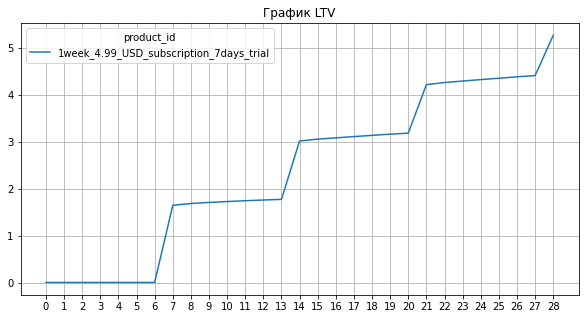

In [81]:
report = result.drop(columns=['cohort_size'])
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('График LTV')
print()

___Вывод___:
- LTV на 28 лайфтайм равен 5.27 USD

### 4. Рассчитать ROMI на 4 недели и на полгода, если стоимость привлечения платящего пользователя 6 USD (ROMI нужно брать операционный, а не бухгалтерский, цель: узнать как окупятся наши инвестиции).

Оставим в таблице только платящих пользователей

In [86]:
#делаю список платящих пользовтателей
pay_user = result_df[['user_id', 'revenue']].groupby('user_id', as_index=False).agg({'revenue':'sum'}).query('revenue > 0')
#добавляю столбец с общим доходом с пользователя
pay_user.columns=('user_id', 'revenue_total')
#оставляю в датасете только платящих пользователей
df_pay_user = result_df[result_df['user_id'].isin(pay_user['user_id'])]
#добавляю к таблице остальные данные датафрейма
df_pay_user = df_pay_user.merge(pay_user, on='user_id')

df_pay_user.head()

,product_id,quantity,is_trial_period,purchase_date,user_id,first_ts,lifetime,revenue,revenue_total
0,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-16,8803657,2020-01-19,28,4.99,19.96
1,1week_4.99_USD_subscription_7days_trial,1,True,2020-01-19,8803657,2020-01-19,0,NaN,19.96
2,1week_4.99_USD_subscription_7days_trial,1,False,2020-01-26,8803657,2020-01-19,7,4.99,19.96
3,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-02,8803657,2020-01-19,14,4.99,19.96
4,1week_4.99_USD_subscription_7days_trial,1,False,2020-02-09,8803657,2020-01-19,21,4.99,19.96


Вычисляю размер когорт для платищих пользователей

In [83]:
cohort_sizes_payer = (
    df_pay_user.groupby('product_id')
    .agg({'user_id': 'nunique'})
    .rename(columns={'user_id': 'cohort_size'})
)

cohort_sizes_payer.head()

,cohort_size
product_id,
1week_4.99_USD_subscription_7days_trial,11405


In [87]:
#строю таблицу с доходом по лайфтаймам для платящих пользователей
result_payer = df_pay_user.pivot_table(
            index='product_id',
            columns='lifetime',
            values='revenue',  # в ячейках — выручка за каждый лайфтайм
            aggfunc='sum',
        )
# считаю сумму выручки с накоплением
result_payer = result_payer.fillna(0).cumsum(axis=1)
#добавляю размер когорт
result_payer = cohort_sizes_payer.merge(result_payer, on='product_id', how='left').fillna(0)
#делю каждую «ячейку» в строке на размер когорты
result_payer = result_payer.div(result_payer['cohort_size'], axis=0)
# исключаем все лайфтаймы, превышающие горизонт анализа
result_payer = result_payer[[0,1]+ list(range(5,29))]
#считаю ROI с учетом того что стоимость привлечения 1 пользователя равна 6 usd
result_payer = result_payer.div(6, axis=0)

print('ROI по лайфтаймам:')
display(result_payer)

ROI по лайфтаймам:


,0,1,5,6,7,8,9,10,11,12,...,19,20,21,22,23,24,25,26,27,28
product_id,,,,,,,,,,,,,,,,,,,,,
1week_4.99_USD_subscription_7days_trial,0.000583,0.000583,0.000656,0.000656,0.709961,0.726441,0.736432,0.74438,0.75211,0.7586,...,1.364138,1.373617,1.819385,1.838855,1.852783,1.866054,1.878451,1.891577,1.902588,2.272882


Строю график ROI

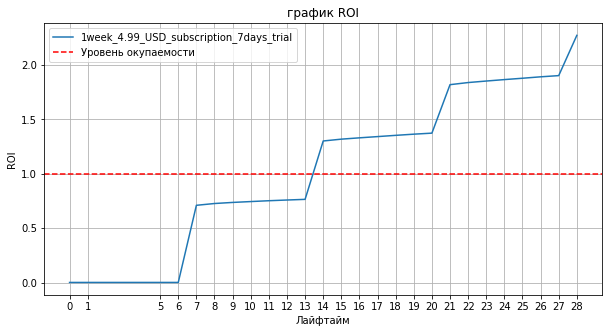

In [85]:
result_payer.T.plot(grid=True, figsize=(10, 5), xticks=list(result_payer.columns.values))

plt.title('график ROI')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()

___Вывод___: 
- ROI для платящих пользователей на 4 недлю(29 день) день составляет 227%
- Стоимость привлечения платящих пользователей окупается на 14 лайфтайм